# Analyzing jogging data recorded in TCX files

I recently got back into the habit of regular jogging, and I have been keeping track of my progress using a free account at mapmyrun.com and their iPhone app. The site, at least in the free tier, lets you explore your data in rather limited ways, but there exists an export option in the TCX ([Training Center XML](https://en.wikipedia.org/wiki/Training_Center_XML)) format. The purpose of this notebook is to play around with that data.

## Contents

- [Extracting the data from the TCX files to Pandas DataFrames](#tcx_import)
- [Classifying routes](#route_classification)
- [Displaying routes on the map](#display_map)

## Initializing the notebook

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import urllib.request
import io
import matplotlib.pyplot as plt

from lxml import objectify
from IPython.display import set_matplotlib_formats
from PIL import Image

set_matplotlib_formats('retina')

## Extracting the data from the TCX files to Pandas DataFrames<a id="tcx_import"></a>

As the name of the format suggests, the TCX files are XML data. Peeking into the file with a text editor quickly reveals the tag hierarchy and makes it easy to write functions to import data summarizing the run:

In [2]:
def read_run_summary(filename):
    """Reads the summary data of a run out of a .tcx file and returns them as
    a Pandas Series.
    """
    # Read the XML file
    tree = objectify.parse(filename)
    root = tree.getroot()
    
    # Based on my running habits, I can safely assume here that there is only
    # the single lap
    lap = root.Activities.Activity.Lap
    start_time = pd.to_datetime(lap.attrib['StartTime'])
    total_time_seconds = float(lap.TotalTimeSeconds)
    distance_meters = float(lap.DistanceMeters)
    maximum_speed = float(lap.MaximumSpeed) # in what units?
    
    return pd.Series({
        'start_time': start_time,
        'total_time_seconds': total_time_seconds,
        'distance_meters': distance_meters,
        'maximum_speed': maximum_speed
    })

In [3]:
read_run_summary("data/Ran 2.51 mi on 07_23_18.tcx.txt")

start_time            2018-07-23 22:48:58
total_time_seconds                   1423
distance_meters                   4046.63
maximum_speed                     6.52455
dtype: object

The app seems to record your position and altitude at one-second intervals, storing them as "trackpoints".

In [4]:
def read_run_trackpoints(filename):
    """Reads the trackpoint data from a .tcx file and returns it as a Pandas
    DataFrame."""
    tree = objectify.parse(filename)
    root = tree.getroot()
    
    timestamp, altitude, latitude, longitude, distance = [], [], [], [], []
    for trackpoint in root.Activities.Activity.Lap.Track.iterchildren():
        timestamp.append(str(trackpoint.Time))
        altitude.append(float(trackpoint.AltitudeMeters))
        latitude.append(float(trackpoint.Position.LatitudeDegrees))
        longitude.append(float(trackpoint.Position.LongitudeDegrees))
        distance.append(float(trackpoint.DistanceMeters))
    
    time = pd.to_datetime(timestamp)
    
    return pd.DataFrame({
        'timestamp': timestamp,
        'altitude_meters': altitude,
        'latitude': latitude,
        'longitude': longitude,
        'distance_meters': distance
    })

In [5]:
read_run_trackpoints("data/Ran 2.51 mi on 07_23_18.tcx.txt").head()

,timestamp,altitude_meters,latitude,longitude,distance_meters
0,2018-07-23T22:48:59+00:00,23.78,41.215496,-73.103262,0.000000
1,2018-07-23T22:49:00+00:00,23.86,41.215490,-73.103247,1.443456
2,2018-07-23T22:49:01+00:00,23.92,41.215487,-73.103236,2.383505
3,2018-07-23T22:49:02+00:00,23.97,41.215488,-73.103227,3.176702
4,2018-07-23T22:49:03+00:00,24.02,41.215491,-73.103216,4.138012


Let's also write a function for collecting the summary of each workout in a folder:

In [6]:
def read_all_runs(directory="data/"):
    """Returns a Pandas DataFrame containing a summary of all the runs in the data
    directory.
    """
    
    runs, files = [], []
    for path, _, filenames in os.walk("data"):
        for filename in filenames:
            filepath = os.path.join(path, filename)
            try:
                run = read_run_summary(filepath)
                runs.append(run)
                files.append(filepath)
            except:
                # if there are any files we can't read, just ignore them
                pass
    
    # Also include a column for the filename, so that we can easily find it
    # if we want to read the details
    summary = pd.DataFrame(runs)
    summary['tcx_file'] = files
    
    return summary

In [7]:
runs = read_all_runs()
runs

,start_time,total_time_seconds,distance_meters,maximum_speed,tcx_file
0,2018-05-23 22:52:26,1605.0,3992.541062,4.335162,data/Ran 2.48 mi on 05_23_18.tcx.txt
1,2018-06-02 19:07:53,1211.0,3155.537341,3.560240,data/Ran 1.96 mi on 06_02_18.tcx.txt
2,2018-07-10 22:57:22,1616.0,4007.507962,5.197376,data/Ran 2.49 mi on 07_10_18.tcx.txt
3,2018-07-18 23:04:41,1414.0,3967.338735,4.607775,data/Ran 2.47 mi on 07_18_18.tcx.txt
4,2018-05-20 21:01:44,1610.0,4087.170490,3.989439,data/Ran 2.54 mi on 05_20_18.tcx.txt
5,2018-06-08 22:24:42,1477.0,3987.133667,4.384211,data/Ran 2.48 mi on 06_08_18.tcx.txt
6,2018-06-11 22:51:03,1455.0,3961.545097,4.529141,data/Ran 2.46 mi on 06_11_18.tcx.txt
7,2018-07-16 22:52:48,1502.0,4048.417486,6.421372,data/Ran 2.52 mi on 07_16_18.tcx.txt
8,2018-04-29 20:16:46,2110.0,4965.212483,3.503269,data/Ran 3.09 mi on 04_29_18.tcx.txt
9,2018-07-23 22:48:58,1423.0,4046.631114,6.524549,data/Ran 2.51 mi on 07_23_18.tcx.txt


The runs seem to be in no particular order.

## Classifying routes<a id="route_classification"></a>

I habitually tend to run the same few routes in the neighborhood, depending on how I feel that particular day. It would be nice to automatically identify the route from the tracking data, so that I could compare a run to other runs of that same route.

When should two routes be considered the same? My first thought was that for each point on one path, there needs to be a point in the other path within a set tolerance. There are two problems with this definition: First, it is not sensitive to the direction you take the path -- and I don't want to consider a loop the same route both ways, because the uphills and downhills are different; Secondly, if there are any loops in the route that I could run in a different order, I want to differentiate between those as well.

So here's the criterion I chose: Two routes are the same, if you can iterate their trackpoints so that you are keeping within the set tolerance from each other. In other words, if for each point on one path (in order) you can find a point within the set distance in the other path without backtracking.

Here is a simple algorithm for checking if path A tracks path B close enough:

```
let point Y be the first point of path B
for point X in path A:
  if point X is not close enough to point Y:
    move point Y along path B until close enough to point X
    if you run out of points on path B, terminate returning false
if the loop completed without terminating early, return true
```

In principle, path A could have all its points close enough to path B but not the other way around (e.g. if there is an extra loop in path B w.r.t. path A), so we need to check this both ways to conclude that the routes are the same.

Another potential issue is that our trackpoint data is in latitudes and longitudes, but we really should calculate the distances in units of length, not degrees. Luckily I'm no ultramarathoner, so the geographic extent of each of my run is small enough that we can do a simple linear approximation:
$$
  y = \frac{\pi}{180^\circ} \times \text{latitude} \times \text{Earth radius}
$$
$$
  x = \frac{\pi}{180^\circ} \times \cos\bigg(\frac{\pi}{180^\circ} \times \text{latitude}\bigg) \times \text{longitude} \times \text{Earth radius}
$$

In [8]:
def is_along_path(path1, path2, tolerance=15):
    """Returns True if path consisting of points (x1, y1) follows the path
    (x2, y2), False otherwise.
    """
    # Avoid computing the square of tolerance repeatedly in the loops below
    squared_tolerance = tolerance**2
    
    path2_iterator = iter(path2)
    x2, y2 = next(path2_iterator)
    
    for x1, y1 in path1:
        # Iterate forward along the path 2 until a point close enough to
        # (x1_value, y1_value) is found, or we run out of points        
        while (x1 - x2)**2 + (y1 - y2)**2 > squared_tolerance:
            try:
                x2, y2 = next(path2_iterator)
            except StopIteration:
                # Reached the end of path2 without finding a point close enough
                return False
    
    # If we finished the for loop without an early return, the path 1 does
    # follow along path 2
    return True

In [9]:
def are_routes_same(run1, run2, tolerance=15):
    """Returns True if the routes of run1 and run2 are the same within the given
    tolerance (in meters).
    """
    
    lon1, lat1 = run1['longitude'].values, run1['latitude'].values
    lon2, lat2 = run2['longitude'].values, run2['latitude'].values
    
    # This approximation for converting degrees to meters is good enough for
    # typical running distances.
    EARTH_RADIUS_METERS = 6137000 # also one radian in latitude in meters
    DEGREE_IN_RADIANS = np.pi/180
    lat_conv = DEGREE_IN_RADIANS * EARTH_RADIUS_METERS
    lon_conv = (np.cos(lat1[0] * DEGREE_IN_RADIANS) * DEGREE_IN_RADIANS
                * EARTH_RADIUS_METERS)
    
    # Convert the iterators to lists because we will iterate them twice below
    path1 = list(zip(lon_conv * lon1, lat_conv * lat1))
    path2 = list(zip(lon_conv * lon2, lat_conv * lat2))
    
    return (is_along_path(path1, path2, tolerance) and
            is_along_path(path2, path1, tolerance))

In [10]:
# Find unique routes on the set of workouts
def classify_routes(workouts, tolerance=100):
    """Classifies the routes on the workouts.
    
    Returns a list of representative runs for unique routes and creates or
    overwrites a column 'route_id' to the workouts DataFrame referring to the
    indices of that list. The tolerance is measured in meters.
    """
    
    unique_routes = []
    workouts['route_id'] = pd.Series(index=workouts.index, dtype=int)
    
    for key, workout in workouts.iterrows():

        run = read_run_trackpoints(workout['tcx_file'])
        route_found = False
        
        if unique_routes:
            for i_route, run2 in enumerate(unique_routes):
                if are_routes_same(run, run2, tolerance):
                    workouts.loc[key, 'route_id'] = i_route
                    route_found = True
                    break
        
        if not route_found:
            workouts.loc[key, 'route_id'] = len(unique_routes)
            unique_routes.append(run)

    return unique_routes

A tolerance of 100 m seems reasonable to me: That way the route is not too sensitive to if I run on where I cross a street (it depends on the traffic) and gives a little tolerance on where exactly I start and stop running.

In [11]:
routes = classify_routes(runs)
runs

,start_time,total_time_seconds,distance_meters,maximum_speed,tcx_file,route_id
0,2018-05-23 22:52:26,1605.0,3992.541062,4.335162,data/Ran 2.48 mi on 05_23_18.tcx.txt,0
1,2018-06-02 19:07:53,1211.0,3155.537341,3.560240,data/Ran 1.96 mi on 06_02_18.tcx.txt,1
2,2018-07-10 22:57:22,1616.0,4007.507962,5.197376,data/Ran 2.49 mi on 07_10_18.tcx.txt,0
3,2018-07-18 23:04:41,1414.0,3967.338735,4.607775,data/Ran 2.47 mi on 07_18_18.tcx.txt,0
4,2018-05-20 21:01:44,1610.0,4087.170490,3.989439,data/Ran 2.54 mi on 05_20_18.tcx.txt,0
5,2018-06-08 22:24:42,1477.0,3987.133667,4.384211,data/Ran 2.48 mi on 06_08_18.tcx.txt,0
6,2018-06-11 22:51:03,1455.0,3961.545097,4.529141,data/Ran 2.46 mi on 06_11_18.tcx.txt,0
7,2018-07-16 22:52:48,1502.0,4048.417486,6.421372,data/Ran 2.52 mi on 07_16_18.tcx.txt,0
8,2018-04-29 20:16:46,2110.0,4965.212483,3.503269,data/Ran 3.09 mi on 04_29_18.tcx.txt,2
9,2018-07-23 22:48:58,1423.0,4046.631114,6.524549,data/Ran 2.51 mi on 07_23_18.tcx.txt,0


## Displaying routes on the map<a id="display_map"></a>

[OpenStreetMap](https://www.openstreetmap.org) offers an option to download map tiles without needing an API key, so let's use that for simplicity. To avoid unnecessary requests to their servers, cache all downloaded tiles to the `tiles` subdirectory. For image quality, it would be better to not turn it into a matplotlib plot, but I'm doing it here anyway for convenience when plotting the route.

In [12]:
TILE_SIZE = 256


def slippy_map_coordinates(lat, lon, zoom_level):
    """Converts latitude and longitude into Slippy Map tile x and y coordinates."""
    
    lat_rad = np.radians(lat)
    n = 2.0 ** zoom_level
    x = (lon + 180.0) / 360.0 * n
    y = (1.0 - np.log(np.tan(lat_rad) + (1 / np.cos(lat_rad))) / np.pi) / 2.0 * n
    
    return x, y


def tile_number(lat, lon, zoom_level):
    """Converts latitude and longitude into Slippy Map tile x and y indices."""
    
    x, y = slippy_map_coordinates(lat, lon, zoom_level)
    x_tile, y_tile = int(x), int(y)
    
    return x_tile, y_tile


def image_coordinate(lat, lon, zoom_level, xmin, ymin):
    """Computes the pixel coordinates in the map image."""
    
    # use np.floor so that we can pass a whole Numpy array through at once
    x, y = slippy_map_coordinates(lat, lon, zoom_level)
    x_image = np.floor((x - xmin) * TILE_SIZE)
    y_image = np.floor((y - ymin) * TILE_SIZE)
    
    return x_image, y_image


def map_tile(zoom, xtile, ytile):
    """Returns the map tile from the tiles cache subdirectory, or failing that,
    from an OpenStreetMap tile server."""
    
    url = r"http://b.tile.openstreetmap.org/{0}/{1}/{2}.png".format(
        zoom, xtile, ytile)
    cache_filename = os.path.join("tiles", f"{zoom}-{xtile}-{ytile}.png")
    
    # Attempt to fetch the tile from the cache directory
    try:
        tile = Image.open(cache_filename)
        return tile
    except:
        pass
    
    # Failing that, attempt to fetch the tile online
    try:
        with urllib.request.urlopen(url) as connection:
            print("Retrieving file: " + url)
            imgstr = connection.read()
        tile = Image.open(io.BytesIO(imgstr))
        tile.save(cache_filename)
        return tile
    except:
        print("Failed to retrieve a tile!")
        return None
        

def map_image(lat_min, lon_min, lat_max, lon_max, zoom):
    """Returns a map image that contains the area (but might extend further,
    depending on the tile borders)."""
    
    # Compute the range of needed tile numbers
    xmin, ymax = tile_number(lat_min, lon_min, zoom)
    xmax, ymin = tile_number(lat_max, lon_max, zoom)
    
    # Combine the tiles to a single image
    im = Image.new('RGB', ((xmax - xmin + 1) * TILE_SIZE - 1,
                           (ymax - ymin + 1) * TILE_SIZE - 1)) 
    for xtile in range(xmin, xmax + 1):
        for ytile in range(ymin, ymax + 1):
            tile = map_tile(zoom, xtile, ytile)
            im.paste(tile,
                     box=((xtile - xmin) * TILE_SIZE, (ytile - ymin) * TILE_SIZE))
    
    return im, xmin, ymin

In [13]:
def plot_route_map(ax, route, margin=0.0005):
    """Plots the route map on the given matplotlib axis."""
    
    lat_min = route['latitude'].min() - margin
    lat_max = route['latitude'].max() + margin
    lon_min = route['longitude'].min() - margin
    lon_max = route['longitude'].max() + margin
    zoom_level = 16
    
    im, xmin, ymin = map_image(lat_min, lon_min, lat_max, lon_max, zoom_level)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(im, extent=[0, im.size[0] - 1, im.size[1] - 1, 0])
    
    x, y = image_coordinate(route['latitude'].values,
                            route['longitude'].values, zoom_level, xmin, ymin)
    ax.plot(x, y, 'r-')
    
    # Crop to the interesting region
    x1, y1 = image_coordinate(lat_min, lon_min, zoom_level, xmin, ymin)
    x2, y2 = image_coordinate(lat_max, lon_max, zoom_level, xmin, ymin)
    
    ax.set_xlim(x1, x2)
    ax.set_ylim(y1, y2)

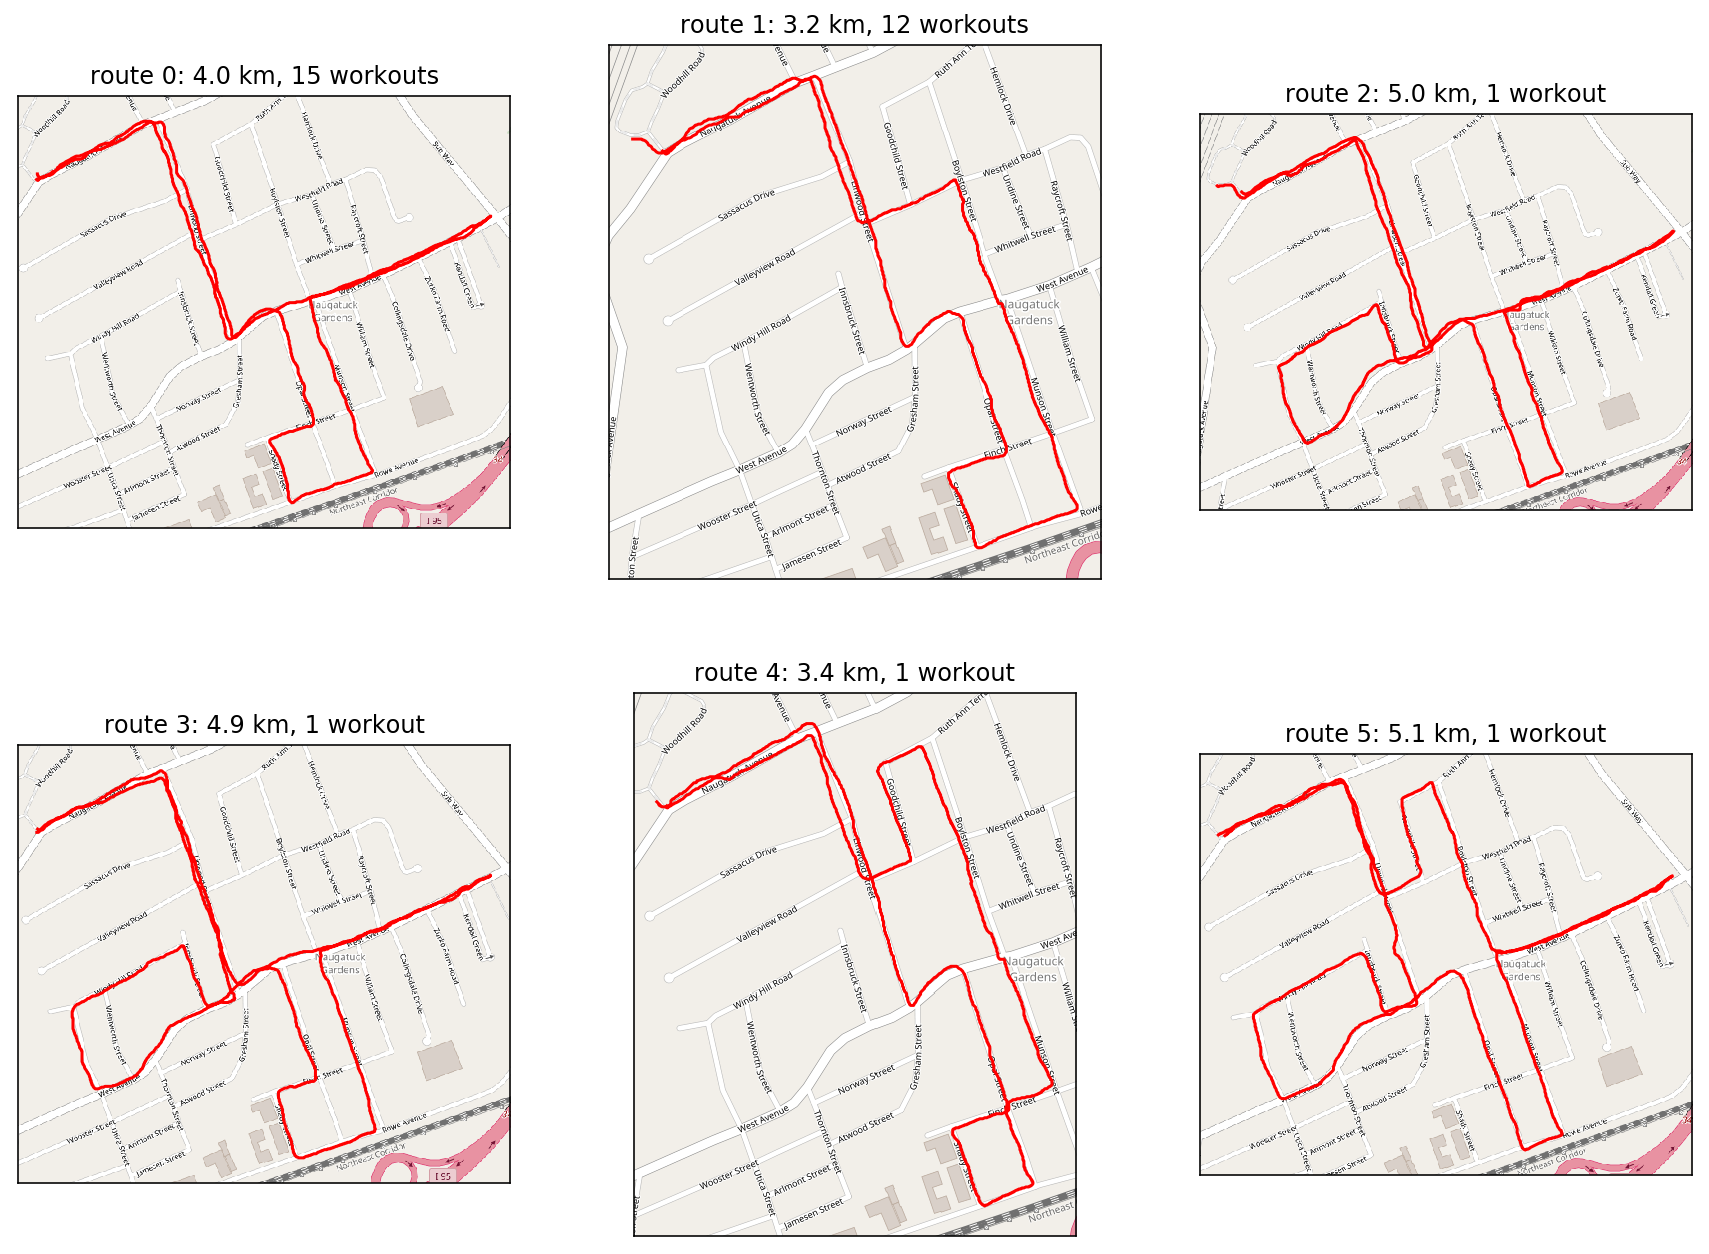

In [14]:
num_cols = 3
num_rows = len(routes)//num_cols + (1 if len(routes) % num_cols > 0 else 0)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15,11), squeeze=False)

# delete the subplots that we're not going to use
if len(routes) % num_cols > 0:
    for i in range(len(routes) % num_cols, num_cols):
        fig.delaxes(axs[num_rows - 1][i])

route_counts = runs['route_id'].value_counts()

for i, (ax, route, count) in enumerate(zip(axs.flatten(), routes, route_counts)):
    plot_route_map(ax, route)
    distance_km = np.round(route['distance_meters'].values[-1]/1e3, 1)
    ax.set_title(f"route {i}: {distance_km} km,"
                 f" {count} workout{'s' if count != 1 else ''}")